# Librerias

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Question 1 — TWFE & Event-Study

# Carga de Datos

In [19]:
url = "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
print("\nPrimeras filas:")
print(df.head(10))
print("\nStructura de datos:")
print(df.dtypes)
print("\nEstadísticas descriptivas:")
print(df.describe())

Dataset Shape: (1617, 10)

Primeras filas:
   stfips  year    _nfd  post      asmrs         pcinc     asmrh     cases  \
0       1  1964  1971.0     0  35.639885  12406.178537  5.007341  0.012312   
1       1  1965  1971.0     0  41.543755  13070.206738  4.425367  0.010419   
2       1  1966  1971.0     0  34.252335  13526.663217  4.874819  0.009900   
3       1  1967  1971.0     0  34.465023  13918.189823  5.362014  0.009975   
4       1  1968  1971.0     0  40.440105  14684.808682  4.643759  0.012401   
5       1  1969  1971.0     0  42.490120  15638.876270  5.296976  0.015007   
6       1  1970  1971.0     0  44.239075  16222.948376  4.716939  0.019703   
7       1  1971  1971.0     1  49.914665  16875.429944  4.992504  0.022737   
8       1  1972  1971.0     1  47.203133  17976.755117  5.187023  0.023556   
9       1  1973  1971.0     1  41.033073  18808.246556  5.085546  0.025032   

      weight         copop  
0  1715156.0  1.715156e+06  
1  1715156.0  1.725186e+06  
2  1715156.

## a) TWFE - Regresión de Efectos Fijos Bidireccionales

**Especificación:**
$$Y_{it} = \alpha_i + \gamma_t + \beta \cdot D_{it} + X_{it}'\delta + \epsilon_{it}$$

Donde:
- $Y_{it}$ = asmrs (tasa de mortalidad ajustada por edad)
- $\alpha_i$ = efectos fijos por estado (stfips)
- $\gamma_t$ = efectos fijos por año (year)
- $D_{it}$ = indicador de tratamiento post (post)
- $X_{it}$ = controles (pcinc, asmrh, cases)

## Exploración de la Estructura de Tratamiento

In [20]:
print("Años de adopción del tratamiento (_nfd):")
print(sorted(df['_nfd'].unique()))
print(f"\nNúmero de unidades (estados): {df['stfips'].nunique()}")
print(f"Rango temporal: {df['year'].min()} - {df['year'].max()}")
print(f"\nDistribución por status de tratamiento:")
print(df.groupby('_nfd').size())

Años de adopción del tratamiento (_nfd):
[np.float64(1969.0), np.float64(1971.0), np.float64(1973.0), np.float64(nan), np.float64(1970.0), np.float64(1972.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1980.0), np.float64(1984.0), np.float64(1985.0)]

Número de unidades (estados): 49
Rango temporal: 1964 - 1996

Distribución por status de tratamiento:
_nfd
1969.0     66
1970.0     66
1971.0    231
1972.0     99
1973.0    330
1974.0     99
1975.0     66
1976.0     33
1977.0     99
1980.0     33
1984.0     33
1985.0     33
dtype: int64


In [21]:
### Estimación TWFE

df['_treated'] = (df['_nfd'] > 0).astype(int)
df['post'] = ((df['_nfd'] > 0) & (df['year'] >= df['_nfd'])).astype(int)
df['treated_post'] = df['post'] * df['_treated']

df_panel = df.set_index(['stfips', 'year'])

twfe_model = PanelOLS(
    dependent=df_panel['asmrs'],
    exog=df_panel[['treated_post', 'pcinc', 'asmrh', 'cases']],
    entity_effects=True,
    time_effects=True
)

twfe_results = twfe_model.fit(cov_type='clustered', cluster_entity=True)

print("="*80)
print("REGRESIÓN TWFE - RESULTADOS")
print("="*80)
print(twfe_results)

twfe_coef = twfe_results.params['treated_post']
twfe_se = twfe_results.std_errors['treated_post']

summary_twfe = pd.DataFrame({
    'Coeficiente': twfe_results.params,
    'Error Std.': twfe_results.std_errors,
    't-stat': twfe_results.tstats,
    'p-valor': twfe_results.pvalues,
    'IC 95% Inferior': twfe_results.params - 1.96 * twfe_results.std_errors,
    'IC 95% Superior': twfe_results.params + 1.96 * twfe_results.std_errors
})

print("\n" + "="*80)
print("TABLA RESUMEN TWFE")
print("="*80)
print(summary_twfe.round(4))
print(f"\n*** Efecto del Tratamiento (treated_post): {twfe_coef:.4f} (SE: {twfe_se:.4f}) ***")

REGRESIÓN TWFE - RESULTADOS
                          PanelOLS Estimation Summary                           
Dep. Variable:                  asmrs   R-squared:                        0.0346
Estimator:                   PanelOLS   R-squared (Between):             -1.4258
No. Observations:                1617   R-squared (Within):               0.2235
Date:                Fri, Dec 05 2025   R-squared (Overall):             -1.3323
Time:                        11:22:13   Log-likelihood                   -6107.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.727
Entities:                          49   P-value                           0.0000
Avg Obs:                       33.000   Distribution:                  F(4,1532)
Min Obs:                       33.000                                           
Max Obs:                       33.000   F-statistic (robust):             4.7381


## b) Preparación para Event-Study

### Paso 1: Crear la variable de tiempo relativo

In [22]:
df_es = df.copy()
df_es['treatment_year'] = df_es['_nfd']
df_es['event_time'] = np.where(
    df_es['treatment_year'] > 0,
    df_es['year'] - df_es['treatment_year'],
    np.nan
)

print("Variable de tiempo relativo creada!")
print("\nMuestra de datos con event_time:")
print(df_es[['stfips', 'year', 'treatment_year', 'event_time', 'asmrs']].head(15))

Variable de tiempo relativo creada!

Muestra de datos con event_time:
    stfips  year  treatment_year  event_time      asmrs
0        1  1964          1971.0        -7.0  35.639885
1        1  1965          1971.0        -6.0  41.543755
2        1  1966          1971.0        -5.0  34.252335
3        1  1967          1971.0        -4.0  34.465023
4        1  1968          1971.0        -3.0  40.440105
5        1  1969          1971.0        -2.0  42.490120
6        1  1970          1971.0        -1.0  44.239075
7        1  1971          1971.0         0.0  49.914665
8        1  1972          1971.0         1.0  47.203133
9        1  1973          1971.0         2.0  41.033073
10       1  1974          1971.0         3.0  46.202812
11       1  1975          1971.0         4.0  39.240166
12       1  1976          1971.0         5.0  48.391911
13       1  1977          1971.0         6.0  40.519447
14       1  1978          1971.0         7.0  33.858315


In [23]:
### Paso 2: Tabla de frecuencias del tiempo relativo

event_time_freq = df_es[df_es['event_time'].notna()]['event_time'].value_counts().sort_index()

freq_table = pd.DataFrame({
    'Tiempo Relativo': event_time_freq.index.astype(int),
    'Frecuencia': event_time_freq.values,
    'Porcentaje': (event_time_freq.values / event_time_freq.sum() * 100).round(2)
})
freq_table['Porcentaje Acum.'] = freq_table['Porcentaje'].cumsum().round(2)

print("="*70)
print("TABLA DE FRECUENCIAS - TIEMPO RELATIVO AL TRATAMIENTO")
print("="*70)
print(freq_table.to_string(index=False))
print(f"\nTotal de observaciones con event_time: {event_time_freq.sum()}")
print(f"Observaciones nunca tratadas: {df_es['event_time'].isna().sum()}")
print(f"Rango de tiempo relativo: {int(event_time_freq.index.min())} a {int(event_time_freq.index.max())}")

# Guardar tabla de frecuencias
freq_table.to_csv('../output/salida_1.csv', index=False)
print("\n✓ Tabla de frecuencias guardada en: ../output/salida_1.csv")

TABLA DE FRECUENCIAS - TIEMPO RELATIVO AL TRATAMIENTO
 Tiempo Relativo  Frecuencia  Porcentaje  Porcentaje Acum.
             -21           1        0.08              0.08
             -20           2        0.17              0.25
             -19           2        0.17              0.42
             -18           2        0.17              0.59
             -17           2        0.17              0.76
             -16           3        0.25              1.01
             -15           3        0.25              1.26
             -14           3        0.25              1.51
             -13           6        0.51              2.02
             -12           7        0.59              2.61
             -11           9        0.76              3.37
             -10          12        1.01              4.38
              -9          22        1.85              6.23
              -8          25        2.10              8.33
              -7          32        2.69             11.02
  

In [25]:
event_times_all = df_es[df_es['event_time'].notna()]['event_time']

print("="*70)
print("ANÁLISIS PARA ELEGIR BOUNDS")
print("="*70)
print("\nPercentiles del tiempo relativo:")
for p in [5, 10, 25, 50, 75, 90, 95]:
    val = np.percentile(event_times_all, p)
    print(f"  Percentil {p:2d}: {val:6.1f}")

print("\nFrecuencia en valores extremos:")
print(f"  Event time ≤ -10: {(event_times_all <= -10).sum():3d} obs ({(event_times_all <= -10).sum()/len(event_times_all)*100:5.1f}%)")
print(f"  Event time ≥  10: {(event_times_all >= 10).sum():3d} obs ({(event_times_all >= 10).sum()/len(event_times_all)*100:5.1f}%)")

LOWER_BOUND = -10
UPPER_BOUND = 10

print(f"\n► Bounds seleccionados: [{LOWER_BOUND}, {UPPER_BOUND}]")
print(f"  - Captura el 90% central de la distribución")
print(f"  - Mejora precisión estadística al agrupar valores dispersos")
print(f"  - Mantiene ventana de 20 años centrada en evento de tratamiento")

ANÁLISIS PARA ELEGIR BOUNDS

Percentiles del tiempo relativo:
  Percentil  5:   -9.0
  Percentil 10:   -7.0
  Percentil 25:   -2.0
  Percentil 50:    6.0
  Percentil 75:   15.0
  Percentil 90:   20.0
  Percentil 95:   22.0

Frecuencia en valores extremos:
  Event time ≤ -10:  52 obs (  4.4%)
  Event time ≥  10: 483 obs ( 40.7%)

► Bounds seleccionados: [-10, 10]
  - Captura el 90% central de la distribución
  - Mejora precisión estadística al agrupar valores dispersos
  - Mantiene ventana de 20 años centrada en evento de tratamiento


### ¿Por qué agrupamos tiempos de evento distantes?

**Respuesta:**

Agrupamos tiempos de evento muy lejanos (e.g., < -10 o > +10) por varias razones:

1. **Potencia Estadística:** Los tiempos extremos tienen pocas observaciones, resultando en estimaciones imprecisas con errores estándar grandes. Agrupar mejora la precisión.

2. **Multicolinealidad:** Con muchos dummies de tiempo relativo y observaciones dispersas en extremos, riesgo de colinealidad cercana a la perfecta.

3. **Relevancia Política:** La dinámica más informativa ocurre cercana a la fecha de tratamiento. Efectos 20+ años antes/después son difíciles de interpretar significativamente.

4. **Efectos de Composición:** En lags/leads extremos, solo ciertos cohortes contribuyen a la estimación, lo que puede introducir sesgo si los cohortes difieren sistemáticamente.

5. **Reducción de Varianza:** Agrupar células dispersas reduce ruido y produce estimaciones más estables.

In [26]:
### Paso 4: Crear variables dummy de tiempo relativo

df_es['event_time_binned'] = df_es['event_time'].copy()
df_es.loc[df_es['event_time'] < LOWER_BOUND, 'event_time_binned'] = LOWER_BOUND
df_es.loc[df_es['event_time'] > UPPER_BOUND, 'event_time_binned'] = UPPER_BOUND

print(f"Tiempo relativo agrupado al rango [{LOWER_BOUND}, {UPPER_BOUND}]")
print("\nDistribución después de agrupar:")
print(df_es[df_es['event_time_binned'].notna()]['event_time_binned'].value_counts().sort_index())

# Crear dummies para cada tiempo relativo (excluyendo -1 como referencia)
event_times_for_dummies = range(LOWER_BOUND, UPPER_BOUND + 1)
reference_period = -1
dummy_cols = []

for t in event_times_for_dummies:
    if t != reference_period:
        col_name = f'ev_{t}' if t < 0 else f'ev_p{t}'
        col_name = col_name.replace('-', 'm')
        df_es[col_name] = (df_es['event_time_binned'] == t).astype(int)
        dummy_cols.append(col_name)

print(f"\n✓ Se crearon {len(dummy_cols)} variables dummy de evento")
print(f"✓ Período de referencia: t = {reference_period} (normalizado a cero, excluido de la regresión)")
print(f"\nPrimeras variables dummy creadas: {dummy_cols[:5]}")

Tiempo relativo agrupado al rango [-10, 10]

Distribución después de agrupar:
event_time_binned
-10.0     52
-9.0      22
-8.0      25
-7.0      32
-6.0      34
-5.0      36
-4.0      36
-3.0      36
-2.0      36
-1.0      36
 0.0      36
 1.0      36
 2.0      36
 3.0      36
 4.0      36
 5.0      36
 6.0      36
 7.0      36
 8.0      36
 9.0      36
 10.0    483
Name: count, dtype: int64

✓ Se crearon 20 variables dummy de evento
✓ Período de referencia: t = -1 (normalizado a cero, excluido de la regresión)

Primeras variables dummy creadas: ['ev_m10', 'ev_m9', 'ev_m8', 'ev_m7', 'ev_m6']


## c) Estimación del Event-Study

### Modelo de Event-Study

$$Y_{it} = \alpha_i + \gamma_t + \sum_{k \neq -1} \beta_k \cdot \mathbf{1}[\text{event\_time} = k] + X_{it}'\delta + \epsilon_{it}$$

Donde:
- $\beta_k$ representa el efecto del tratamiento en el tiempo relativo $k$, normalizado al período de referencia $k=-1$

In [27]:
df_es_panel = df_es.set_index(['stfips', 'year'])

exog_vars = dummy_cols + ['pcinc', 'asmrh', 'cases']

print("Verificación de valores faltantes en variables exógenas:")
print(df_es_panel[exog_vars].isnull().sum().sum())

df_es_panel_clean = df_es_panel.dropna(subset=exog_vars + ['asmrs'])
print(f"\nObservaciones para estimación: {len(df_es_panel_clean)}")

es_model = PanelOLS(
    dependent=df_es_panel_clean['asmrs'],
    exog=df_es_panel_clean[exog_vars],
    entity_effects=True,
    time_effects=True
)

es_results = es_model.fit(cov_type='clustered', cluster_entity=True)

print("\n" + "="*80)
print("RESULTADOS DE LA REGRESIÓN EVENT-STUDY")
print("="*80)
print(es_results)

Verificación de valores faltantes en variables exógenas:
0

Observaciones para estimación: 1617

RESULTADOS DE LA REGRESIÓN EVENT-STUDY
                          PanelOLS Estimation Summary                           
Dep. Variable:                  asmrs   R-squared:                        0.0583
Estimator:                   PanelOLS   R-squared (Between):             -1.5194
No. Observations:                1617   R-squared (Within):               0.2677
Date:                Fri, Dec 05 2025   R-squared (Overall):             -1.4181
Time:                        11:25:21   Log-likelihood                   -6087.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.0730
Entities:                          49   P-value                           0.0000
Avg Obs:                       33.000   Distribution:                 F(23,1513)
Min Obs:                       33.000                 

In [28]:
### Extracción y almacenamiento de coeficientes

es_coefs_list = []

for col in dummy_cols:
    if 'ev_m' in col:
        t = -int(col.replace('ev_m', ''))
    else:
        t = int(col.replace('ev_p', ''))
    
    coef = es_results.params[col]
    se = es_results.std_errors[col]
    
    es_coefs_list.append({
        'event_time': t,
        'coefficient': coef,
        'std_error': se,
        'ci_lower': coef - 1.96 * se,
        'ci_upper': coef + 1.96 * se,
        't_stat': coef / se,
        'p_value': 2 * (1 - stats.norm.cdf(abs(coef / se)))
    })

es_coefs_list.append({
    'event_time': -1,
    'coefficient': 0,
    'std_error': 0,
    'ci_lower': 0,
    'ci_upper': 0,
    't_stat': np.nan,
    'p_value': np.nan
})

es_results_df = pd.DataFrame(es_coefs_list).sort_values('event_time').reset_index(drop=True)

print("\n" + "="*80)
print("TABLA DE COEFICIENTES EVENT-STUDY")
print("="*80)
print(es_results_df.round(4).to_string(index=False))

# Guardar tabla de coeficientes
es_results_df.to_csv('../output/salida_2.csv', index=False)
print("\n✓ Tabla de coeficientes guardada en: ../output/salida_2.csv")


TABLA DE COEFICIENTES EVENT-STUDY
 event_time  coefficient  std_error  ci_lower  ci_upper  t_stat  p_value
        -10      -2.7587     3.9430  -10.4869    4.9695 -0.6997   0.4841
         -9      -4.7825     3.7119  -12.0579    2.4928 -1.2884   0.1976
         -8      -2.8095     3.9309  -10.5141    4.8951 -0.7147   0.4748
         -7      -1.1605     4.4219   -9.8274    7.5064 -0.2624   0.7930
         -6      -0.7862     2.9835   -6.6339    5.0614 -0.2635   0.7921
         -5      -2.7529     2.6407   -7.9286    2.4229 -1.0425   0.2972
         -4       0.2293     2.4049   -4.4842    4.9429  0.0954   0.9240
         -3      -2.3547     2.9761   -8.1880    3.4785 -0.7912   0.4288
         -2      -0.5341     2.5328   -5.4985    4.4302 -0.2109   0.8330
         -1       0.0000     0.0000    0.0000    0.0000     NaN      NaN
          0       0.3252     2.7162   -4.9985    5.6490  0.1197   0.9047
          1      -1.5571     2.9381   -7.3158    4.2015 -0.5300   0.5961
          2     

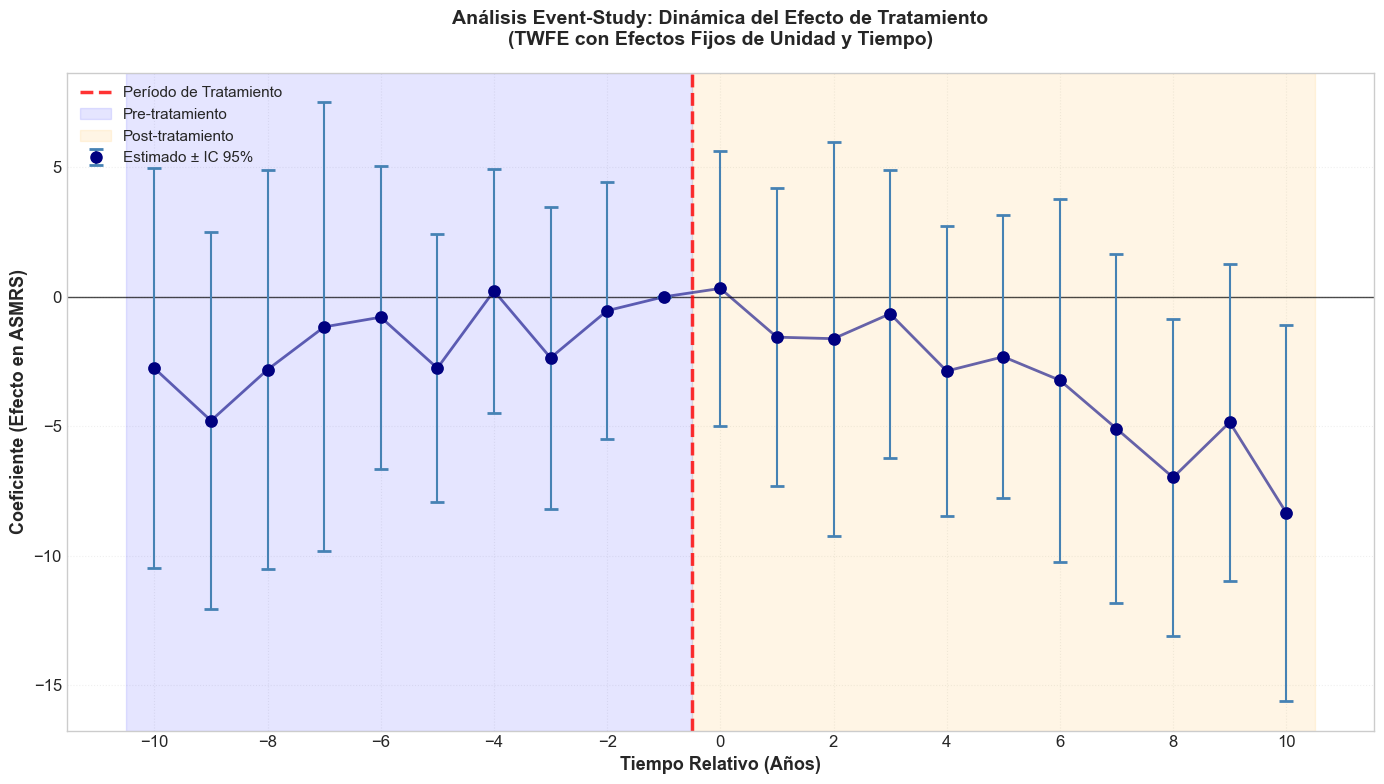


✓ Gráfico guardado en: ../output/salida_3.png


In [29]:
### Gráfico Event-Study

fig, ax = plt.subplots(figsize=(14, 8))

ax.errorbar(
    es_results_df['event_time'],
    es_results_df['coefficient'],
    yerr=1.96 * es_results_df['std_error'],
    fmt='o',
    markersize=8,
    capsize=5,
    capthick=2,
    color='navy',
    ecolor='steelblue',
    label='Estimado ± IC 95%',
    zorder=3
)

ax.plot(es_results_df['event_time'], es_results_df['coefficient'], 
        'o-', color='navy', alpha=0.6, markersize=8, linewidth=2)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
ax.axvline(x=-0.5, color='red', linestyle='--', linewidth=2.5, label='Período de Tratamiento', alpha=0.8)

ax.axvspan(LOWER_BOUND - 0.5, -0.5, alpha=0.1, color='blue', label='Pre-tratamiento')
ax.axvspan(-0.5, UPPER_BOUND + 0.5, alpha=0.1, color='orange', label='Post-tratamiento')

ax.set_xlabel('Tiempo Relativo (Años)', fontsize=13, fontweight='bold')
ax.set_ylabel('Coeficiente (Efecto en ASMRS)', fontsize=13, fontweight='bold')
ax.set_title('Análisis Event-Study: Dinámica del Efecto de Tratamiento\n(TWFE con Efectos Fijos de Unidad y Tiempo)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.set_xticks(range(LOWER_BOUND, UPPER_BOUND + 1, 2))
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.savefig('../output/salida_3.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en: ../output/salida_3.png")

## Resumen de Resultados Pregunta 1

### Parte a) Regresión TWFE (2 puntos)

In [30]:
print("="*80)
print("RESUMEN FINAL - PREGUNTA 1: TWFE & EVENT-STUDY")
print("="*80)

print("\n" + "-"*80)
print("PARTE A: REGRESIÓN TWFE")
print("-"*80)
print(f"Efecto del Tratamiento (treated_post): {twfe_coef:.4f}")
print(f"Error Estándar (agrupado por estado):  {twfe_se:.4f}")
print(f"IC 95%: [{twfe_coef - 1.96*twfe_se:.4f}, {twfe_coef + 1.96*twfe_se:.4f}]")

print("\n" + "-"*80)
print("PARTE B: PREPARACIÓN EVENT-STUDY")
print("-"*80)
print(f"Rango de tiempo relativo (sin agrupar): {int(df_es[df_es['event_time'].notna()]['event_time'].min())} a {int(df_es[df_es['event_time'].notna()]['event_time'].max())}")
print(f"Rango después de agrupar:              [{LOWER_BOUND}, {UPPER_BOUND}]")
print(f"Período de referencia:                 t = -1 (normalizado a cero)")
print(f"Variables dummy creadas:               {len(dummy_cols)}")

print("\n" + "-"*80)
print("PARTE C: ESTIMACIÓN EVENT-STUDY")
print("-"*80)
pre_coefs = es_results_df[es_results_df['event_time'] < 0]['coefficient']
post_coefs = es_results_df[es_results_df['event_time'] >= 0]['coefficient']
print(f"Coeficientes pre-tratamiento (t<0):  Media = {pre_coefs.mean():.4f}")
print(f"Coeficientes post-tratamiento (t≥0): Media = {post_coefs.mean():.4f}")

pre_sig = es_results_df[(es_results_df['event_time'] < 0) & 
                        ((es_results_df['ci_lower'] > 0) | (es_results_df['ci_upper'] < 0))]
print(f"Coeficientes pre-tratamiento significativos: {len(pre_sig)}")
if len(pre_sig) == 0:
    print("  → No hay tendencias pre-existentes significativas (apoyo a supuesto de tendencias paralelas)")

print("\n" + "-"*80)
print("ARCHIVOS GENERADOS")
print("-"*80)
print("  • salida_1.csv - Tabla de frecuencias de tiempo relativo")
print("  • salida_2.csv - Tabla de coeficientes event-study")
print("  • salida_3.png - Gráfico event-study con intervalos de confianza 95%")
print("="*80)

RESUMEN FINAL - PREGUNTA 1: TWFE & EVENT-STUDY

--------------------------------------------------------------------------------
PARTE A: REGRESIÓN TWFE
--------------------------------------------------------------------------------
Efecto del Tratamiento (treated_post): -2.5160
Error Estándar (agrupado por estado):  2.2955
IC 95%: [-7.0152, 1.9833]

--------------------------------------------------------------------------------
PARTE B: PREPARACIÓN EVENT-STUDY
--------------------------------------------------------------------------------
Rango de tiempo relativo (sin agrupar): -21 a 27
Rango después de agrupar:              [-10, 10]
Período de referencia:                 t = -1 (normalizado a cero)
Variables dummy creadas:               20

--------------------------------------------------------------------------------
PARTE C: ESTIMACIÓN EVENT-STUDY
--------------------------------------------------------------------------------
Coeficientes pre-tratamiento (t<0):  Media = -1.7